In [3]:
import matplotlib.pyplot as plt
import xarray as xr


url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.2016.nc'
ds = xr.open_dataset(url)

In [4]:
#slicing 
lat_slice = slice(-26,-10)
long_slice= slice(142,156)

gbr_ds = ds.sel(lat=lat_slice,lon=long_slice)
print("New size :", gbr_ds.sst.shape)

New size : (366, 64, 56)


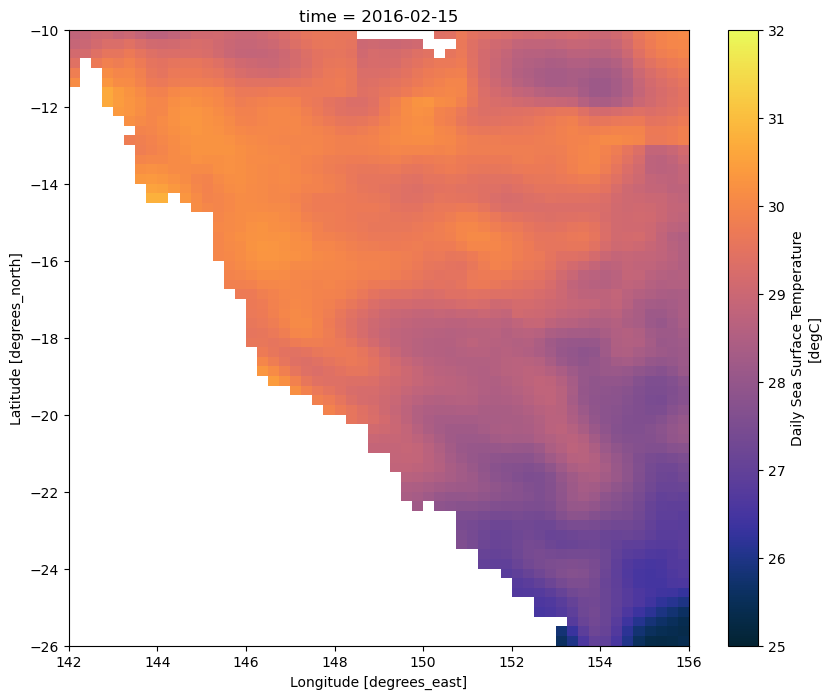

In [5]:
import cmocean

gbr_ds.sst.sel(time='2016-02-15').plot(figsize=(10,8),cmap=cmocean.cm.thermal,vmin=25,vmax=32)

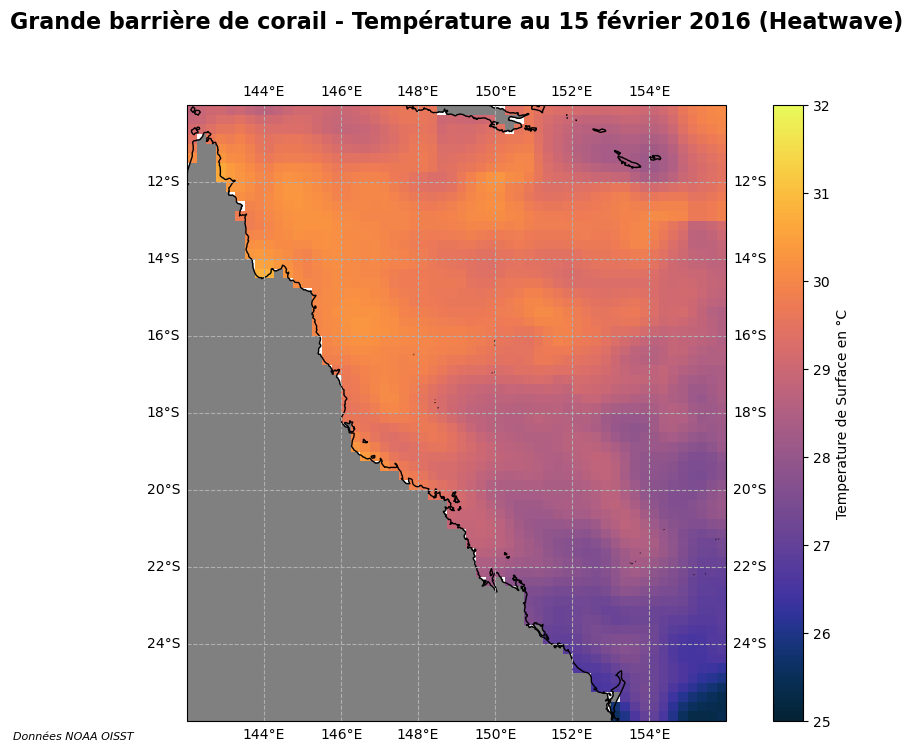

In [6]:
import cartopy.crs as ccrs #earth projection
import cartopy.feature as cfeature #coast & earth shape

plt.figure(figsize=(12,8))
ax_1 = plt.axes(projection=ccrs.PlateCarree())
ax_1.add_feature(cfeature.LAND, color='grey')
ax_1.add_feature(cfeature.COASTLINE)
ax_1.gridlines(draw_labels=True, linestyle='--')

gbr_ds.sst.sel(time='2016-02-15').plot(
    ax=ax_1,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
    vmin=25,vmax=32,
    cbar_kwargs={'label':'Temperature de Surface en °C'}
)

ax_1.set_title('Grande barrière de corail - Température au 15 février 2016 (Heatwave)', fontsize=16, fontweight='bold',pad=40)
ax_1.text(-0.1,-0.03,'Données NOAA OISST',transform=ax_1.transAxes,ha='right', fontsize=8, fontstyle='italic',)
plt.show()

In [7]:
#Add climatology (long term mean) to compare the data

climatology_url= 'http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.ltm.1991-2020.nc'
climatology_ds = xr.open_dataset(climatology_url)

gbr_climatology = climatology_ds.sel(lat=lat_slice,lon=long_slice)


/var/folders/lq/vng5lskj14dfywjvkw5_l9bh0000gn/T/ipykernel_5477/791854240.py:4: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  climatology_ds = xr.open_dataset(climatology_url)
/var/folders/lq/vng5lskj14dfywjvkw5_l9bh0000gn/T/ipykernel_5477/791854240.py:4: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  climatology_ds = xr.open_dataset(climatology_url)


In [8]:
#Cleaning 2016 (366 days year)

def is_leap_day(date):
    return (date.dt.month == 2) & (date.dt.day == 29)

gbr_2016 = gbr_ds.sel(time=~is_leap_day(gbr_ds.time)) 

print(f'taille origine {gbr_ds.time.size} & taille sans 29 fev {gbr_2016.time.size}')

#Cleaning time format matching

gbr_clim_aligned = gbr_climatology.copy()
gbr_clim_aligned['time'] = gbr_2016['time']

#Slicing for the first season of 2016 to light

time_slice = slice('2016-01-01', '2016-03-31')
gbr_2016_season = gbr_2016.sel(time=time_slice)
gbr_clim_season = gbr_clim_aligned.sel(time=time_slice)

taille origine 366 & taille sans 29 fev 365


Min: -1.9103317
Max: 3.2676678


Text(-0.1, -0.1, 'Données NOAA OISST')

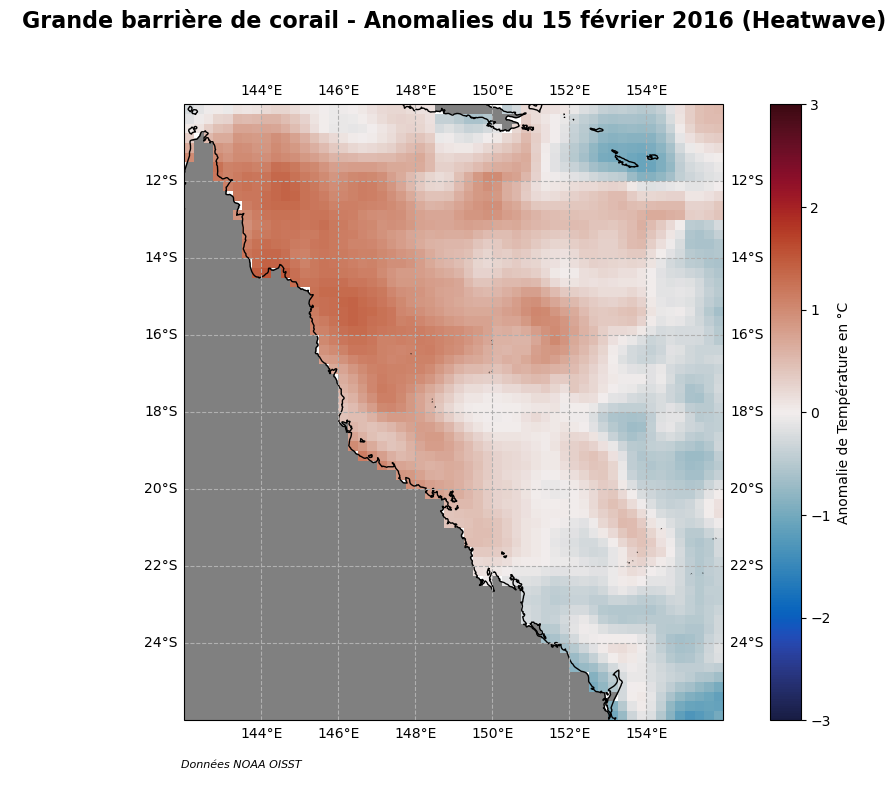

In [9]:
#Anomaly detection

ds_2016 = xr.open_dataset('/Users/maxencelefour/Desktop/Data Projects/aussie-marine-heatwave-analysis-main/data/gbr_2016_season.nc')
ds_clim = xr.open_dataset('/Users/maxencelefour/Desktop/Data Projects/aussie-marine-heatwave-analysis-main/data/gbr_clim_season.nc')


anomaly_2016 = ds_2016.sst - ds_clim.sst
print("Min:", anomaly_2016.min().values)
print("Max:", anomaly_2016.max().values)

plt.figure(figsize=(12,8))
ax_anomaly=plt.axes(projection=ccrs.PlateCarree())
ax_anomaly.add_feature(cfeature.LAND,color='grey')
ax_anomaly.add_feature(cfeature.COASTLINE)
ax_anomaly.gridlines(draw_labels=True,linestyle='--')

anomaly_2016.sel(time="2016-02-15").plot(
    ax=ax_anomaly,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.balance,
    vmin=-3,
    vmax=3,
    cbar_kwargs={'label':'Anomalie de Température en °C'}
)

ax_anomaly.set_title('Grande barrière de corail - Anomalies du 15 février 2016 (Heatwave)', fontsize=16, fontweight='bold',pad=40)
ax_anomaly.text(-0.1,-0.1,'Données NOAA OISST',transform=ax_1.transAxes,ha='right', fontsize=8, fontstyle='italic',)

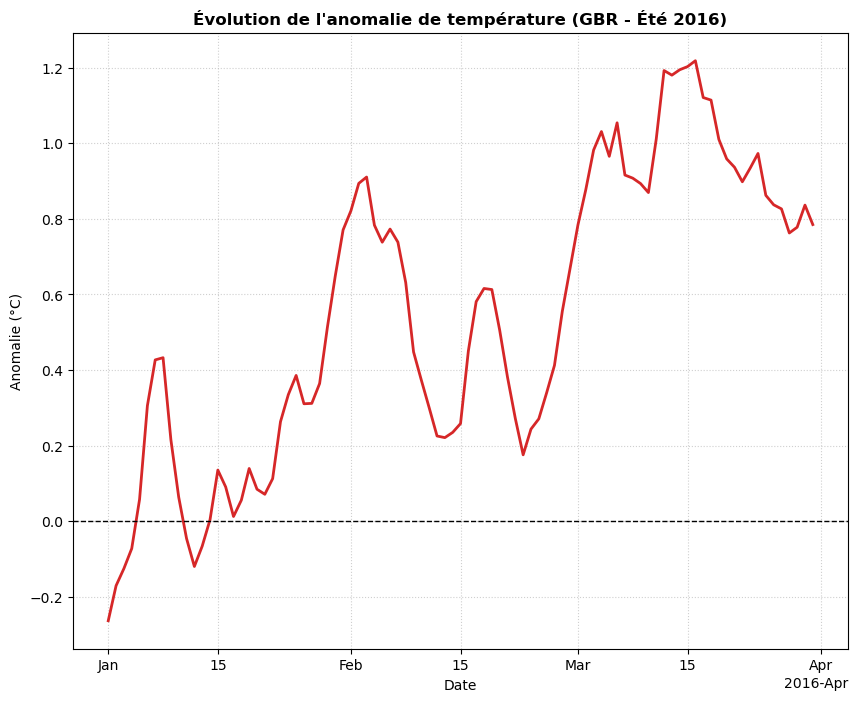

In [10]:
#Flat the dataset to have 1D datas and plot time series

ts_anomaly = anomaly_2016.mean(dim=['lat','lon'])
ts_anomaly.head()

fig, ax_var = plt.subplots(figsize=(10,8))

ts_anomaly.plot(
    ax=ax_var,
    color='tab:red',
    linewidth=2
)

ax_var.axhline(0, color='k', linestyle='--', linewidth=1) # La ligne zéro
ax_var.set_title('Évolution de l\'anomalie de température (GBR - Été 2016)', fontsize=12, fontweight='bold')
ax_var.set_ylabel('Anomalie (°C)')
ax_var.set_xlabel('Date')
ax_var.grid(True, linestyle=':', alpha=0.6)

plt.show()

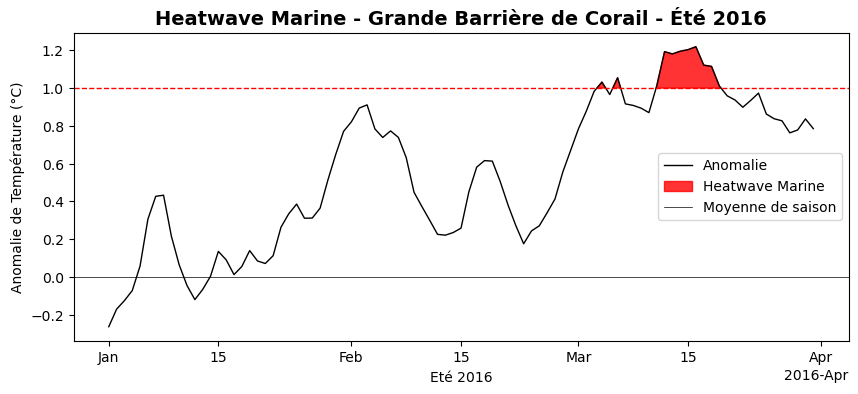

In [11]:
#Detect marine heatwave events based on a threshold

treshold = 1.0

fig, ax = plt.subplots(figsize=(10,4))
ts_anomaly.plot(
    ax = ax,
    color='black',
    linewidth=1,
    label='Anomalie'
)

ax.fill_between(ts_anomaly.time,treshold,ts_anomaly,where=(ts_anomaly>=treshold),color='red',alpha=0.8,interpolate=True,label='Heatwave Marine')
ax.axhline(treshold, color='red', linestyle='--', linewidth=1)
ax.axhline(0, color='k', linestyle='-', linewidth=0.5,label='Moyenne de saison')

ax.set_title('Heatwave Marine - Grande Barrière de Corail - Été 2016', fontsize=14, fontweight='bold')
ax.set_ylabel('Anomalie de Température (°C)')
ax.set_xlabel('Eté 2016')
ax.legend()
fig.savefig('Anomalie_heatwave_marine.png', dpi=300)


In [12]:
#Some calcul

heatwave_days = (ts_anomaly >= treshold).sum().values
print(f"Nombre de jours au-dessus du seuil critique : {heatwave_days} jours")

Nombre de jours au-dessus du seuil critique : 11 jours


/opt/miniconda3/envs/gbr_analysis/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/lq/vng5lskj14dfywjvkw5_l9bh0000gn/T/ipykernel_5477/3027560345.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "wo" (-> color='w'). The keyword argument will take precedence.
  ax_heatwave_days_map.plot(lon, lat, 'wo', color='black',markersize=5, transform=ccrs.PlateCarree(), zorder=102)
/var/folders/lq/vng5lskj14dfywjvkw5_l9bh0000gn/T/ipykernel_5477/3027560345.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "wo" (-> color='w'). The keyword argument will take precedence.
  ax_heatwave_days_map.plot(lon, lat, 'wo', color='black',markersize=5, transform=ccrs.PlateCarree(), zorder=102)


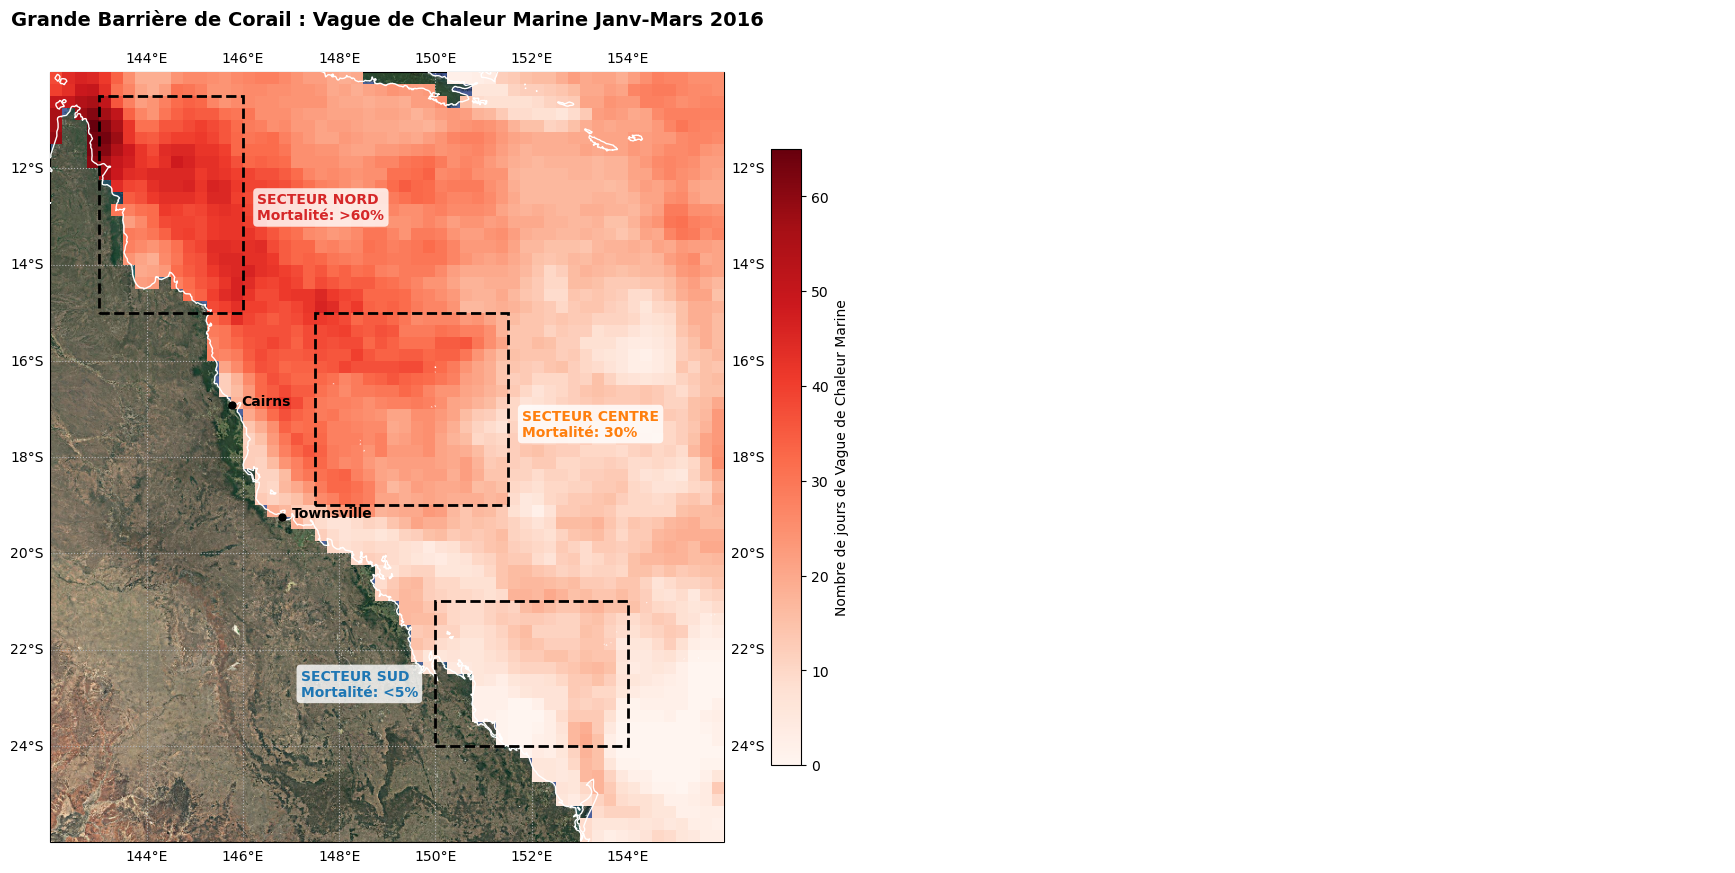

In [13]:
#Stress map

import matplotlib.patches as mpatches
from cartopy.io.img_tiles import GoogleTiles as GT

heatwave_days_map = (anomaly_2016 >= treshold).sum(dim='time')

is_land = ds_2016.sst.isel(time=0).isnull()
heatwave_days_map = heatwave_days_map.where(~is_land)

fig, ax_heatwave_days_map = plt.subplots(
    figsize=(12, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

tiler = GT(style='satellite')
ax_heatwave_days_map.add_image(tiler, 8,zorder=1)
ax_heatwave_days_map.add_feature(cfeature.COASTLINE,linewidth=1,color='white',zorder=102)
ax_heatwave_days_map.gridlines(draw_labels=True, linestyle=':')

heatwave_days_map.plot(
    ax=ax_heatwave_days_map,
    cmap='Reds',
    vmin=0,
    vmax=heatwave_days_map.max(),
    cbar_kwargs={'label':'Nombre de jours de Vague de Chaleur Marine','shrink': 0.8},
    zorder=100
)

ax_heatwave_days_map.set_title('Grande Barrière de Corail : Vague de Chaleur Marine Janv-Mars 2016', fontsize=14, fontweight='bold',y=1.05)
ax_heatwave_days_map.text(2.6,0.05,'Données NOAA OISST V2',transform=ax_1.transAxes,ha='left', fontsize=8, fontstyle='italic',)

cities = {
    'Cairns': (145.77, -16.92),
    'Townsville': (146.81, -19.25)
}

for city, (lon, lat) in cities.items():
    ax_heatwave_days_map.plot(lon, lat, 'wo', color='black',markersize=5, transform=ccrs.PlateCarree(), zorder=102)
    ax_heatwave_days_map.text(lon + 0.2, lat, city, color='black', fontsize=10, transform=ccrs.PlateCarree(), zorder=102, fontweight='bold')


# Zone NORTH 

north_box = mpatches.Rectangle((143, -15), 3, 4.5, linewidth=2, edgecolor='black', facecolor='none', linestyle='--', transform=ccrs.PlateCarree(), zorder=130)
ax_heatwave_days_map.add_patch(north_box)
ax_heatwave_days_map.text(146.3, -12.5, 'SECTEUR NORD\nMortalité: >60%', color='#d62728', fontsize=10, fontweight='bold', 
        ha='left', va='top', transform=ccrs.PlateCarree(), zorder=130, 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

# 2. Zone CENTRAL
south_box = mpatches.Rectangle((147.5, -19), 4, 4, linewidth=2, edgecolor='black', facecolor='none', linestyle='--', transform=ccrs.PlateCarree(), zorder=130)
ax_heatwave_days_map.add_patch(south_box)
ax_heatwave_days_map.text(151.8, -17, 'SECTEUR CENTRE\nMortalité: 30%', color='#ff7f0e', fontsize=10, fontweight='bold', 
        ha='left', va='top', transform=ccrs.PlateCarree(), zorder=103, 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

# 3. Zone SOUTH
south_box = mpatches.Rectangle((150, -24), 4, 3, linewidth=2, edgecolor='black', facecolor='none', linestyle='--', transform=ccrs.PlateCarree(), zorder=130)
ax_heatwave_days_map.add_patch(south_box)
ax_heatwave_days_map.text(147.2, -22.4, 'SECTEUR SUD\nMortalité: <5%', color='#1f77b4', fontsize=10, fontweight='bold', 
        ha='left', va='top', transform=ccrs.PlateCarree(), zorder=103, 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))
ax_heatwave_days_map.set_extent([142, 156, -26, -10], crs=ccrs.PlateCarree())
fig.savefig('carte_heatwave-2016.png', dpi=300, bbox_inches='tight')
